In [1]:
import os

from lxml import etree
import base64
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from urllib.parse import urljoin

import numpy as np

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

BYWEB_PATH = os.path.join('data', 'byweb_for_course')

In [2]:
class Document:
    def __init__(self, raw):
        self.raw = raw

In [3]:
def pipeline(docs, foo_list):
    for foo in foo_list:
        def generator(docs, foo):
            for doc in docs:
                yield foo(doc)
        docs = generator(docs, foo)
    return docs

def generate_raw_docs(db_path):
    for file_name in tqdm(os.listdir(db_path)[:1]):
        file_path = os.path.join(db_path, file_name)
        root = etree.parse(file_path).getroot()
        for raw in root.getchildren():
            yield Document(raw)
            break

In [4]:
def decoded_doc(doc):
    doc.html, doc.url, doc.doc_id = \
        list(map(lambda x: x.text, doc.raw))
    doc.url = base64.urlsafe_b64decode(doc.url).decode('cp1251')
    doc.html = base64.b64decode(doc.html).decode('cp1251')
    return doc

In [5]:
def build_text(doc):
    soup = BeautifulSoup(doc.html, 'lxml')
    for script in soup(['script', 'style']):
        script.decompose()
    doc.text = soup.get_text()
    doc.text = re.sub('(<!--.*?-->)', '', doc.text, flags=re.DOTALL)
    return doc

In [6]:
def tokenize(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    doc.tokens = tokenizer.tokenize(doc.text)
    return doc

In [7]:
docs = generate_raw_docs(BYWEB_PATH)
count = sum(1 for _ in docs)
print('Count of docs: {}'.format(count))


Count of docs: 1



Mean doc length in bytes: 4046.0


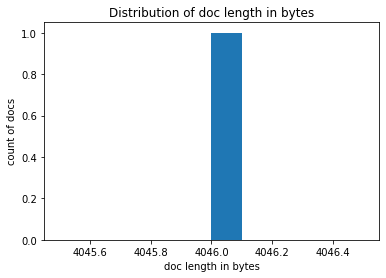

In [8]:
docs = pipeline(generate_raw_docs(BYWEB_PATH),
                [decoded_doc, build_text])
lens = list(map(lambda x: len(x.text), docs))

print('Mean doc length in bytes: {}'.format(np.array(lens).mean()))

plt.hist(lens)
plt.xlabel('doc length in bytes')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in bytes')
plt.show()


Mean doc length in words: 489.0


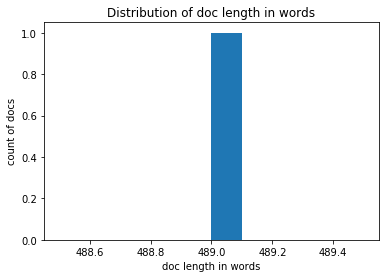

In [9]:
docs = pipeline(generate_raw_docs(BYWEB_PATH),
                [decoded_doc, build_text, tokenize])
lens = list(map(lambda x: len(x.tokens), docs))

print('Mean doc length in words: {}'.format(np.array(lens).mean()))

plt.hist(lens)
plt.xlabel('doc length in words')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in words')
plt.show()

In [10]:
def find_links(doc):
    soup = BeautifulSoup(doc.html)
    for script in soup(["script", "style"]):
        script.decompose()
    
    doc.links = set()
    for link in soup.findAll('a'):
        link_url = link.get('href')
        if not link_url or link_url[0] == '#':
            continue
        try:
            link_url = urljoin(url, link_url)
            doc.links.add(link_url)
        except Exception:
            pass
        
    return doc

In [16]:
from multiprocessing import Pool

def get():
    for x in range(10):
        yield x
        
def foo1(x):
    return x + 2
        
def foo2(x):
    print('_', x)
    return x * 2
        
def bar(x):
    print(x)
    
docs = pipeline(get(), [foo1, foo2])

with Pool(processes=10) as pool:
    res = pool.map(bar, docs)

6
4
14
10
12
22
16
20
18
8
_ 2
_ 3
_ 4
_ 5
_ 6
_ 7
_ 8
_ 9
_ 10
_ 11
